# MODELS

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import nltk
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

df = pd.read_csv('data.csv')

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

In [2]:
# Download stopwords and include some of our own
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
include_stopwords = {'on','lyrics','remix','like'}
stopwords |= include_stopwords
features = df.drop(["Genre"], axis=1)
labels = df[["Genre"]]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sebpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, random_state=42, test_size=0.2)

In [4]:
X_train = X_train['Lyrics']
X_test = X_test['Lyrics']
y_train = y_train['Genre']
y_test = y_test['Genre']

features = features["Lyrics"]
labels = labels["Genre"]

# First Model (SVC)

In [5]:
# Preprocess the data and create a pipeline
class LowercaseTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [text.lower() for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

text_clf_SVC = Pipeline([
    ('lowercase', LowercaseTransformer()),
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('clf', SVC())
])

In [6]:
# Train the classifier
text_clf_SVC.fit(X_train, y_train)

Pipeline(steps=[('lowercase',
                 <__main__.LowercaseTransformer object at 0x0000021888CA6EB0>),
                ('tfidf',
                 TfidfVectorizer(stop_words=['up', 'themselves', "you'll",
                                             'wasn', 'at', 'that', "mightn't",
                                             'theirs', 'below', 'can', 'his',
                                             'why', 'same', 'and', 'such', 'ma',
                                             'out', 'y', 'only', "hasn't",
                                             "haven't", 'a', 'under', 'there',
                                             'o', 'won', 'are', "should've",
                                             'i', "hadn't", ...])),
                ('clf', SVC())])

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# Predict the test set results

# Is the model Overfitting
print(accuracy_score(y_train, text_clf_SVC.predict(X_train)))


y_pred = text_clf_SVC.predict(X_test)

mean_accuracy_train = cross_val_score(text_clf_SVC, features, labels, cv=3, scoring="accuracy").mean()


print(f"Accuracy, Cross-Validation: { mean_accuracy_train }")
print(classification_report(y_test, y_pred))

0.995
Accuracy, Cross-Validation: 0.8940071663901114
              precision    recall  f1-score   support

     country       0.86      1.00      0.93        50
         rap       1.00      0.84      0.91        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



# Second Model (Naive Bayes Multinomial)

In [8]:
# Preprocess the data and create a pipeline
class LowercaseTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [text.lower() for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

text_clf_bayes = Pipeline([
    ('lowercase', LowercaseTransformer()),
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords))),
    ('clf', MultinomialNB())
])

In [9]:
# Train the classifier
text_clf_bayes.fit(X_train, y_train)

Pipeline(steps=[('lowercase',
                 <__main__.LowercaseTransformer object at 0x0000021889F49430>),
                ('tfidf',
                 TfidfVectorizer(stop_words=['up', 'themselves', "you'll",
                                             'wasn', 'at', 'that', "mightn't",
                                             'theirs', 'below', 'can', 'his',
                                             'why', 'same', 'and', 'such', 'ma',
                                             'out', 'y', 'only', "hasn't",
                                             "haven't", 'a', 'under', 'there',
                                             'o', 'won', 'are', "should've",
                                             'i', "hadn't", ...])),
                ('clf', MultinomialNB())])

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# Predict the test set results

# Is the model Overfitting
print(accuracy_score(y_train, text_clf_bayes.predict(X_train)))


y_pred = text_clf_bayes.predict(X_test)

mean_accuracy_train = cross_val_score(text_clf_bayes, features, labels, cv=3, scoring="accuracy").mean()

print(f"Accuracy, Cross-Validation: { mean_accuracy_train }")
print(classification_report(y_test, y_pred))

0.9775
Accuracy, Cross-Validation: 0.8680470384532141
              precision    recall  f1-score   support

     country       0.94      0.88      0.91        50
         rap       0.89      0.94      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



# Grid CV Search

In [18]:
# Grid for SVC
parameters = {
    'tfidf__use_idf': [True, False],
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__C': [1e-3, 1e-2, 0.1, 1]
}

gs_clf = GridSearchCV(text_clf_SVC, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(features, labels)

mean_accuracy_train = cross_val_score(gs_clf, features, labels, cv=3, scoring="accuracy").mean()
print(f"Accuracy, Cross-Validation: { mean_accuracy_train }")

gs_clf.best_params_

Accuracy, Cross-Validation: 0.897975134069211


{'clf__C': 1, 'clf__kernel': 'linear', 'tfidf__use_idf': True}

In [19]:
# Grid for Naive Bayes
parameters = {
    'tfidf__use_idf': [True, False],
    'clf__fit_prior': [True, False],
    'clf__alpha': [1e-3, 1e-2, 1e-1, 1]
}

gs_clf = GridSearchCV(text_clf_bayes, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(features, labels)

mean_accuracy_train = cross_val_score(gs_clf, features, labels, cv=3, scoring="accuracy").mean()
print(f"Accuracy, Cross-Validation: { mean_accuracy_train }")

gs_clf.best_params_

Accuracy, Cross-Validation: 0.9060192867277492


{'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__use_idf': True}

# Final Model (Best Model was Naive Bayes)

In [11]:
# Preprocess the data and create a pipeline
class LowercaseTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [text.lower() for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

text_clf = Pipeline([
    ('lowercase', LowercaseTransformer()),
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords), use_idf=False)),
    ('clf', MultinomialNB(alpha=0.01, fit_prior=True))
])

In [12]:
# Train the classifier
text_clf.fit(X_train, y_train)

Pipeline(steps=[('lowercase',
                 <__main__.LowercaseTransformer object at 0x0000021888D2BA60>),
                ('tfidf',
                 TfidfVectorizer(stop_words=['up', 'themselves', "you'll",
                                             'wasn', 'at', 'that', "mightn't",
                                             'theirs', 'below', 'can', 'his',
                                             'why', 'same', 'and', 'such', 'ma',
                                             'out', 'y', 'only', "hasn't",
                                             "haven't", 'a', 'under', 'there',
                                             'o', 'won', 'are', "should've",
                                             'i', "hadn't", ...],
                                 use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01))])

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# Predict the test set results

# Is the model Overfitting
print(accuracy_score(y_train, text_clf.predict(X_train)))


y_pred = text_clf.predict(X_test)

mean_accuracy_train = cross_val_score(text_clf, features, labels, cv=3, scoring="accuracy").mean()


print(f"Accuracy, Cross-Validation: { mean_accuracy_train }")
print(classification_report(y_test, y_pred))

0.995
Accuracy, Cross-Validation: 0.9100353509847774
              precision    recall  f1-score   support

     country       0.94      0.94      0.94        50
         rap       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



# Model Analysis

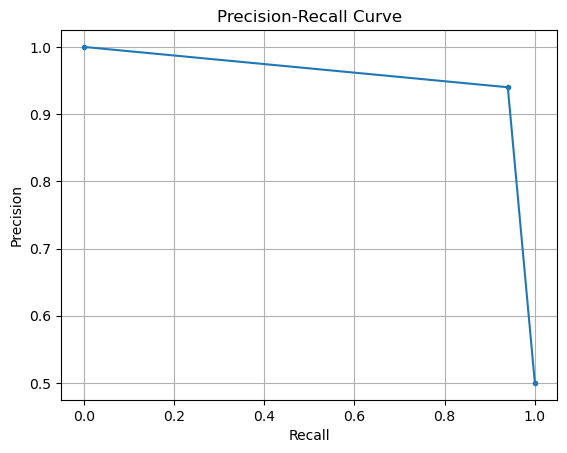

In [14]:
# Convert 'country' to 1 and 'rap' to 0 in y_test
y_test_binary = np.where(y_test == 'country', 1, 0)
# Convert 'country' to 1 and 'rap' to 0 in y_pred
y_pred_binary = np.where(y_pred == 'country', 1, 0)

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_binary)

# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

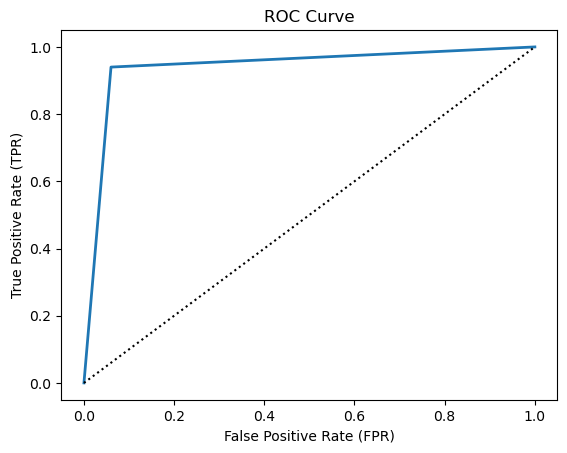

In [15]:
fpr, tpr ,thresholds = roc_curve(y_test_binary, y_pred_binary)
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

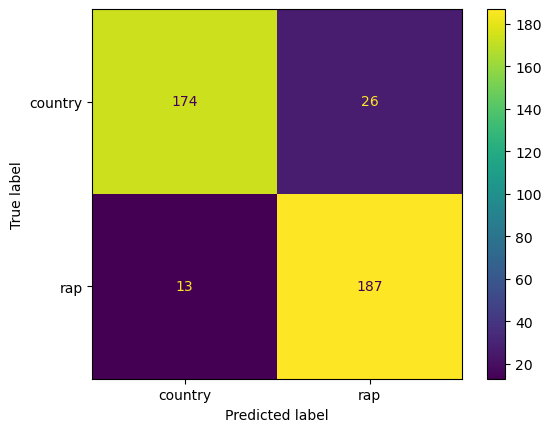

In [16]:
y_train_pred = cross_val_predict(text_clf, X_train, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

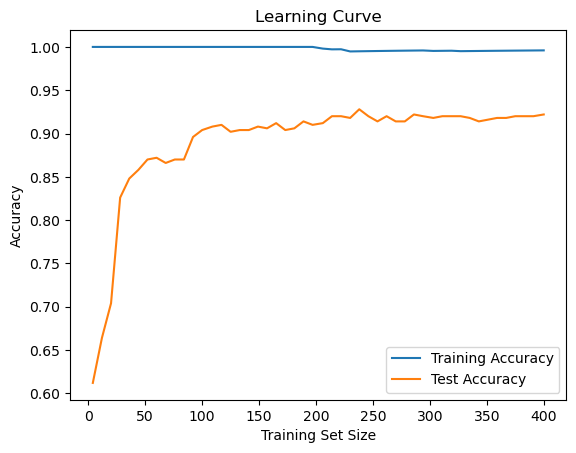

In [17]:
train_sizes, train_scores, test_scores = learning_curve(text_clf, features, labels, cv=5, scoring="accuracy", n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label="Training Accuracy")
plt.plot(train_sizes, test_scores_mean, label="Test Accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()